In [1]:
# import set 
using Turing
using Distances
using LinearAlgebra
using LimberJack
using Interpolations
using GaussianProcess
using Plots
using QuadGK
using BlockDiagonals
using PrettyTables
using NPZ
using CSV
using DataFrames

In [2]:
# supernovae data
# supernovae_raw = CSV.read("DES_Dovekie_HD.csv", DataFrame);
# supernovae = filter!(row -> row.MUERR < 5, supernovae_raw)
# supernovae_raw = CSV.read("DES_Dovekie_HD.csv", DataFrame);
# supernovae = supernovae_raw[supernovae_raw.MUERR .< 5, :]
# function data_mu()
#     z = supernovae[!,"zHD"][1:20:end]
#     z_hel = supernovae[!,"zHEL"][1:20:end]
#     data = supernovae[!,"MU"][1:20:end]
#     err = supernovae[!,"MUERR"][1:20:end]
    
#     cov = zeros(length(z), length(z))
#     for i in 1:length(z)
#         cov[i, i] = err[i]^2
#     end
    
#     return (data_name = "data_mu", z = z, data = data, err = err, cov = cov)
# end


In [3]:
supernovae_raw = CSV.read("DES_Dovekie_HD.csv", DataFrame);
supernovae = supernovae_raw[supernovae_raw.MUERR .< 5, :];

z = supernovae[!,"zHD"];
z_hel = supernovae[!,"zHEL"];
data = supernovae[!,"MU"];
err = supernovae[!,"MUERR"];

# cov = zeros(length(z), length(z))
# for i in 1:length(z)
#     cov[i, i] = err[i]^2
# end



1743-element Vector{Float64}:
 0.1773
 0.1641
 0.1331
 0.1211
 0.1559
 0.1246
 0.1135
 0.1105
 0.1516
 0.122
 ⋮
 0.1353
 0.228
 0.133
 0.2373
 0.1451
 0.1518
 0.1075
 0.1585
 0.1512

In [4]:
# superdata = npzread("STAT+SYS.npz");
# println(keys(superdata))  # lists all variable names in the file
# pretty_table(superdata["cov"])

In [5]:
# datamu = data_mu();
function hz_from_ez(zarr, h0, ez)
    ez_itp = LinearInterpolation(zarr, ez, extrapolation_bc=Line())
    hz = ez_itp(zarr) .* (h0*100)
    return hz
end

function dm_from_ez(zarr, h0, ez)
    chis = similar(ez)
    ez_itp = LinearInterpolation(zarr, ez, extrapolation_bc=Line())

    for i in 1:length(zarr)
        zz = zarr[i]
        chis[i] = quadgk(z -> 1.0/ez_itp(z), 0.0, zz, rtol=1E-5)[1]
        chis[i] *= LimberJack.CLIGHT_HMPC / h0
    end
    return chis
end


dm_from_ez (generic function with 1 method)

In [ ]:
cl = 299_792_458;
function d_lum(z_hel, zarr, h0, ez)
    dlz = (1 .+ z_hel) .* dm_from_ez(zarr, h0, ez)
    return dlz
end

function mu_init(z_hel, zarr, h0, M0, ez)
    Msamp = M0 + 5*log10(cl/(h0*100))
    mu_initz = 5 .* log10.((cl/ (h0*100)) .* (d_lum(z_hel, zarr, h0, ez) ./ 10) ) .- 19.3 .- Msamp  .+ 25
    return mu_initz
end

# function mu(z_hel, zarr, h0, M, ez)
#     M_samp = M + 5*log10(LimberJack.CLIGHT_HMPC/(h0*100))
#     muz = mu_init(z_hel, zarr, h0, ez) .+ 19.3 .+ M_samp
#     return muz
# end
# −29.96210
# (LimberJack.CLIGHT_HMPC*100)

mu_init (generic function with 1 method)

In [14]:
cosmo1 = Cosmology();
z_integ1 = cosmo1.settings.zs;
ez_test = Ez(cosmo1, z_integ1);

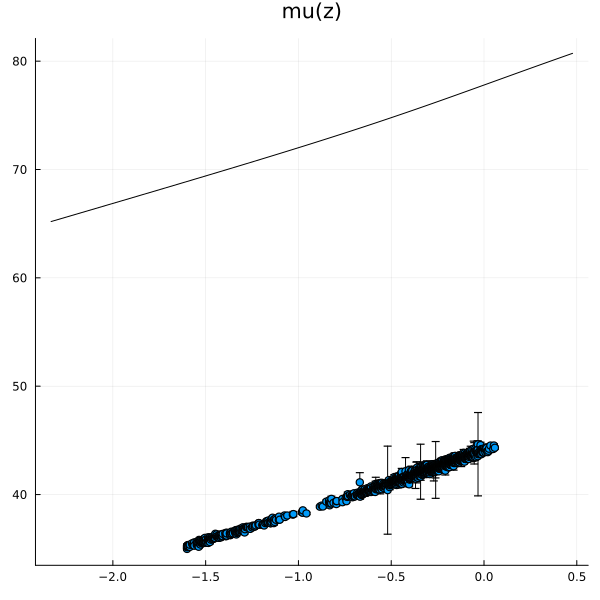

In [15]:
p4 = plot(log10.(z), data, yerr=err, seriestype=:scatter, title="mu(z)", legend=false)
plot!(p4, log10.(z_integ1), mu_init(z_integ1, z_integ1, 0.67, -19.3, ez_test), color=:black)
plot(p4, layout=(1,1), size=(600,600))